# Load Qick

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qick_workspace.tools import system_cfg
from qick_workspace.tools.system_tool import select_config_idx
from qick import *
from qick.pyro import make_proxy
from qick import QickConfig
from qick.asm_v2 import QickSpan, QickSweep1D
import Pyro4

Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION = 4

ns_host = "192.168.10.63"
ns_port = 8888
proxy_name = "myqick"

soc, soccfg = make_proxy(ns_host=ns_host, ns_port=ns_port, proxy_name=proxy_name)
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_100127414b1446cf94bc54217e2af34c@192.168.10.63:43131
QICK running on ZCU216, software version 0.2.371

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc timing clock, DAC tile 0, DAC tile 1, DAC tile 3], [DAC tile 2], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230 on JHC3, or QICK box DAC port 8
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 4096 complex samples (0.427 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230 on JHC4, or QICK box DAC port 9
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 8192 complex samples (0.855 us)
		32-bit DDS, range=9584.

# Qubit setting

In [3]:
# Define the qubit index
qubit_idx = 0

config = {
    **system_cfg.hw_cfg,
    **system_cfg.readout_cfg,
    **system_cfg.qubit_cfg,
    **system_cfg.expt_cfg,
    **system_cfg.cool_cfg,
}


In [4]:
from qubit import Fluxonium
from qubit import phi_to_flux, flux_to_phi

target_phi = 0.5  # Target flux value in the range [0, 1]
target_flux = -2.2
phi = flux_to_phi(target_flux, (-7.99, 3.57), (0, 0.5))
flux = phi_to_flux(target_phi, (-7.99, 3.57), (0, 0.5))

q = Fluxonium(EJ=5.57, EC=0.966, EL=0.702, dimention=51, flux=phi)


flux = phi_to_flux(target_phi, (-7.99, 3.57), (0, 0.5))
print("V=", flux)
phi = flux_to_phi(target_flux, (-7.99, 3.57), (0, 0.5))
print("phi =", phi)

print(q.f01(), "GHz")

V= 3.5700000000000003
phi = 0.2504325259515571
5.549423257388396 GHz


# QB estimation

In [5]:
from qubit import Fluxonium
from qubit import phi_to_flux, flux_to_phi

target_phi = 0.5  # Target flux value in the range [0, 1]
target_flux = 1.22
phi = flux_to_phi(target_flux, (12.6, 1.22), (0, 0.5))
flux = phi_to_flux(target_phi, (12.6, 1.22), (0, 0.5))

q = Fluxonium(EJ=5.57, EC=0.966, EL=0.702, dimention=51, flux=phi)


flux = phi_to_flux(target_phi, (12.6, 1.22), (0, 0.5))
print("V=", flux)
phi = flux_to_phi(target_flux, (12.6, 1.22), (0, 0.5))
print("phi =", phi)

print(q.f01(), "GHz")

V= 1.2200000000000006
phi = 0.5
0.1347743777040188 GHz


# TOF

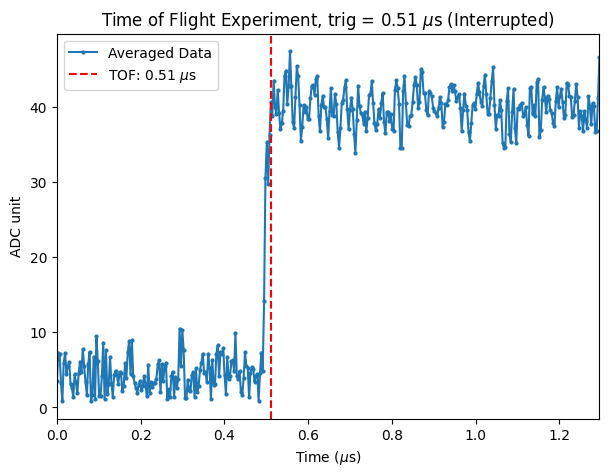

In [16]:
from qick_workspace.scrip.s001_time_of_flight import TOF

run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    {
        "res_freq_ge": 6000,
        "ro_length": 1.3,
        "res_legnth": 0.2,
        "res_gain_ge": 1,
        "res_ch": 0,
    }
)

tof = TOF(soc, soccfg, run_cfg)
tof.run(100, liveplot=True)
# tof.plot()

config["trig_time"] = 0.49

# YOKO setting

In [6]:
from qick_workspace.tools.YOKOGS200 import YOKOGS200
import pyvisa

rm = pyvisa.ResourceManager()
yoko_connect = "USB0::0x0B21::0x0039::91WB18859::INSTR"
yoko = YOKOGS200(yoko_connect, rm)

yoko.OutputOn()
# yoko.OutputOff()

## Current mode

In [4]:
# yoko.SetMode('current')
# yokocurrent = 0*1e-3
# yoko.SetCurrent(yokocurrent)
# yoko.GetCurrent()

## Voltage mode

In [5]:
# yoko.SetMode("voltage")
# yoko_value = -12.6
# yoko.SetVoltage(yoko_value, _rampstep=1e-2)
# # yoko.GetVoltage()
# print(yoko.GetValue())
# yoko_value = yoko.GetValue()

In [4]:
yoko_value = yoko.GetValue()
yoko_value

{'unit': 'A', 'value': -0.00258}

# GE state

## Resonator OneTone

In [7]:
from qick_workspace.scrip.s002_res_spec_ge import Resonator_onetone

START_FREQ = config["res_freq_ge"][qubit_idx] - 10  # [MHz]
STOP_FREQ = config["res_freq_ge"][qubit_idx] + 10  # [MHz]

STEPS = 101


config["res_gain_ge"][qubit_idx] = 0.2
run_cfg = select_config_idx(config, qubit_idx)

run_cfg.update(
    [
        ("steps", STEPS),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("relax_delay", 1),
        ("cooling", False),
    ]
)

onetone = Resonator_onetone(soc, soccfg, run_cfg)
fres = onetone.run(py_avg=20, liveplot=True, solve_type="hm")
## update value ##
config["res_freq_ge"][qubit_idx] = round(fres[0] / 1e6, 4)
onetone.saveLabber(qubit_idx, yoko_value=yoko_value)


{'Fres(GHz)': np.float64(5.3511),
 'Qi': 1491,
 'Ql': -402,
 'absQc': -317,
 'κ(MHz)': np.float64(-13.3)}


c:\Users\QEL\Desktop\SQC_soc\qick_workspace\abcd_rf_fit\abcd_rf_fit.py:187: UserWarning: Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False
  warnings.warn("Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False", UserWarning)
Traceback (most recent call last):
  File "c:\Users\QEL\Anaconda3\envs\qick2env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\QEL\AppData\Local\Temp\ipykernel_56920\717874730.py", line 25, in <module>
    onetone.saveLabber(qubit_idx, yoko_value=yoko_value)
NameError: name 'yoko_value' is not defined


## OneTone PunchOut

In [34]:
from qick_workspace.scrip.s002b_res_punchout_ge import (
    SingleToneSpectroscopyPunchout,
)

run_cfg = select_config_idx(config, qubit_idx)

START_FREQ = config["res_freq_ge"][qubit_idx] - 7  # [MHz]
STOP_FREQ = config["res_freq_ge"][qubit_idx] + 7  # [MHz]
STEPS_freq = 101

START_gain = 0.01  # [MHz]
STOP_gain = 1  # [MHz]
STEPS_gain = 21
run_cfg.update(
    [
        ("f_steps", STEPS_freq),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("g_steps", STEPS_gain),
        ("res_gain_ge", QickSweep1D("gainloop", START_gain, STOP_gain)),
    ]
)
punchout = SingleToneSpectroscopyPunchout(soc, soccfg, run_cfg)
punchout.run(py_avg=10, liveplot=True)
punchout.saveLabber(qubit_idx)

2025-11-06 12:11:05,485 - SR_Network:BlockingClient - Error: Socket operation timed out


Data save to C:\Users\QEL\Desktop\2DQ12round3\2025\11\Data_1106\002b_res_ge_punchout_Q3_011


## Onetone Flux

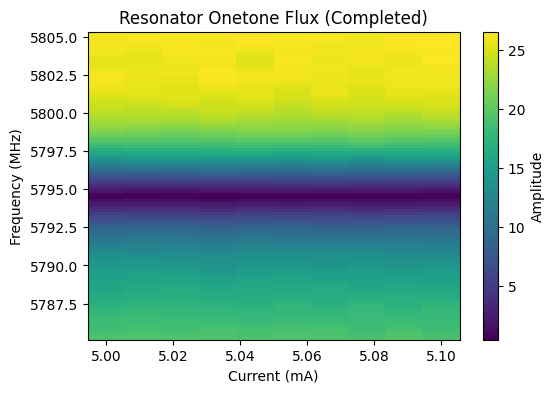

2025-11-06 13:12:55,680 - SR_Network:BlockingClient - Error: Socket operation timed out


Data save to C:\Users\QEL\Desktop\2DQ12round3\2025\11\Data_1106\s002_onetone_flux_Q3_033


In [35]:
from qick_workspace.scrip.s002c_res_spec_ge_flux import (
    Resonator_onetone_flux,
)


run_cfg = select_config_idx(config, qubit_idx)

START_FREQ = config["res_freq_ge"][qubit_idx] - 10  # [MHz]
STOP_FREQ = config["res_freq_ge"][qubit_idx] + 10  # [MHz]

STEPS = 101

Start_flux = 5.1e-3
Stop_flux = 5e-3
Steps_flux = 10
yoko_range = np.linspace(Start_flux, Stop_flux, Steps_flux)
run_cfg.update(
    [
        ("steps", STEPS),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("relax_delay", 1),
    ]
)

onetone_flux = Resonator_onetone_flux(soc, soccfg, run_cfg)
onetone_flux.run(
    5, liveplot=True, yoko_inst=yoko_connect, yoko_value=yoko_range, mode="current"
)
onetone_flux.saveLabber(qubit_idx, yoko_range, mode="current")

## Hardware loop

In [115]:
# from single_qubit_pyscrip_v1_1.s002c_res_spec_ge_flux import Resonator_onetone_flux

# run_cfg = select_config_idx(config, qubit_idx)

# START_FREQ = 5000
# STOP_FREQ = 6000
# STEPS = 101
# yoko_range = np.linspace(0, 1, 21)*1e-3
# run_cfg.update([('steps', STEPS),
#                 ('steps_flux', 21),
#                 ('flux_ch', 2),
#                 ('flux_length', 10),
#                 ('saturate_times', 0.5),
#                 ('res_freq_ge', QickSweep1D('freqloop', START_FREQ, STOP_FREQ)),
#                 ('flux_gain', QickSweep1D('fluxloop', -0.01, 0.01)),
#                 ('relax_delay', 1)
#                 ])

# onetone_flux = Resonator_onetone_flux(soc, soccfg, run_cfg)
# onetone_flux.liveplot_hardwre(50)

## Cooling sweep

In [28]:
# from single_qubit_pyscrip_v1_2.s002d_res_cooling_ge import SingleToneSpectroscopyCooling

# run_cfg = select_config_idx(config, qubit_idx)
# SPAN1 = 20
# cooling_freq = {}
# cooling_freq["f12"] = 6.303
# cooling_freq["f0g1"] = 1.290
# START_FREQ_1 = round(cooling_freq["f12"] * 1e3, 3) - SPAN1  # [MHz]
# STOP_FREQ_1 = round(cooling_freq["f12"] * 1e3, 3) + SPAN1  # [MHz]
# STEPS_freq_1 = 31

# SPAN2 = 20
# START_FREQ_2 = round(cooling_freq["f0g1"] * 1e3, 3) - SPAN2  # [MHz]
# STOP_FREQ_2 = round(cooling_freq["f0g1"] * 1e3, 3) + SPAN2  # [MHz]
# STEPS_freq_2 = 31

# config.update(
#     [
#         ("cool_ch1", 5),
#         ("cool_gain_1", 0.5),
#         ("nqz_cool_ch1", 2),
#         ("cool_mixer1", round(cooling_freq["f12"] * 1e3, 3)),
#         ("cool_ch2", 7),
#         ("cool_gain_2", 0.5),
#         ("nqz_cool_ch2", 2),
#         ("cool_mixer2", round(cooling_freq["f0g1"] * 1e3, 3)),
#         ("cool_length", 2),
#     ]
# )

# run_cfg.update(
#     [
#         ("f_steps1", STEPS_freq_1),
#         ("cool_freq_1", QickSweep1D("freqloop1", START_FREQ_1, STOP_FREQ_1)),
#         ("f_steps2", STEPS_freq_2),
#         ("cool_freq_2", QickSweep1D("freqloop2", START_FREQ_2, STOP_FREQ_2)),
#     ]
# )
# cooling = SingleToneSpectroscopyCooling(soc, soccfg, run_cfg)
# cooling.run(py_avg=30, liveplot=True)
# cooling.saveLabber(qubit_idx)

In [29]:
# config.update(
#     [
#         ("cool_ch1", 5),
#         ("cool_freq_1", 6309),
#         ("cool_gain_1", 0.5),
#         ("nqz_cool_ch1", 2),
#         ("cool_mixer1", 6309),
#         ("cool_ch2", 7),
#         ("cool_freq_2", 1278),
#         ("cool_gain_2", 0.5),
#         ("nqz_cool_ch2", 2),
#         ("cool_mixer2", 1278),
#         ("cool_length", 3),
#     ]
# )


## Qubit Spectrum ge

Experiment interrupted at 21 averages. Fit is based on partial data.


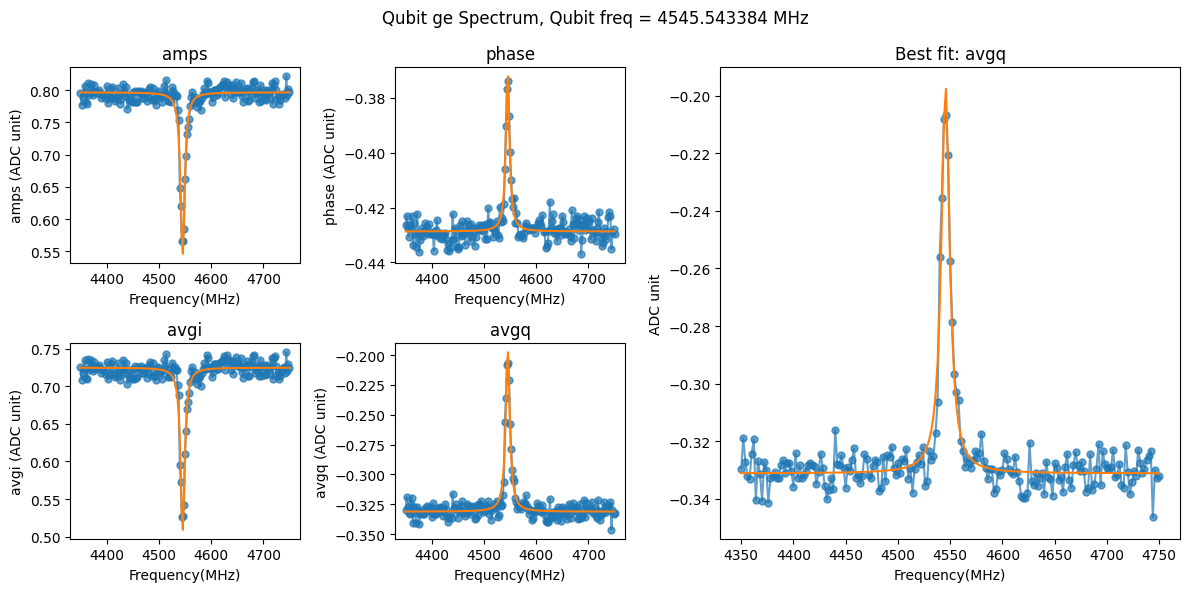

In [8]:
from qick_workspace.scrip.s003_qubit_spec_ge import Qubit_Twotone

center = 4550
SPAN = 200
START_FREQ = center - SPAN  # [MHz]
STOP_FREQ = center + SPAN  # [MHz]

STEPS = 201

config["nqz_qubit"] = 2

run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixer_freq", center),
        ("qubit_gain_ge", 0.3),
        ("res_gain_ge", 0.3),
        ("qubit_length_ge", 5),
        ("relax_delay", 1),
        ("cooling", False),
        ("qubit_ch", 5),
    ]
)

spectrum_ge = Qubit_Twotone(soc, soccfg, run_cfg)
f_ge = spectrum_ge.run(200, liveplot=True)
config["qubit_freq_ge"][qubit_idx] = f_ge
config["qmixer_freq"][qubit_idx] = f_ge
# spectrum_ge.saveLabber(qubit_idx, yoko_value=yoko_value)

Current: -0.0013 A, Qubit Freq: 4508.630268 MHz

Successfully finished sweep. Final report saved to qubit_auto_test.json


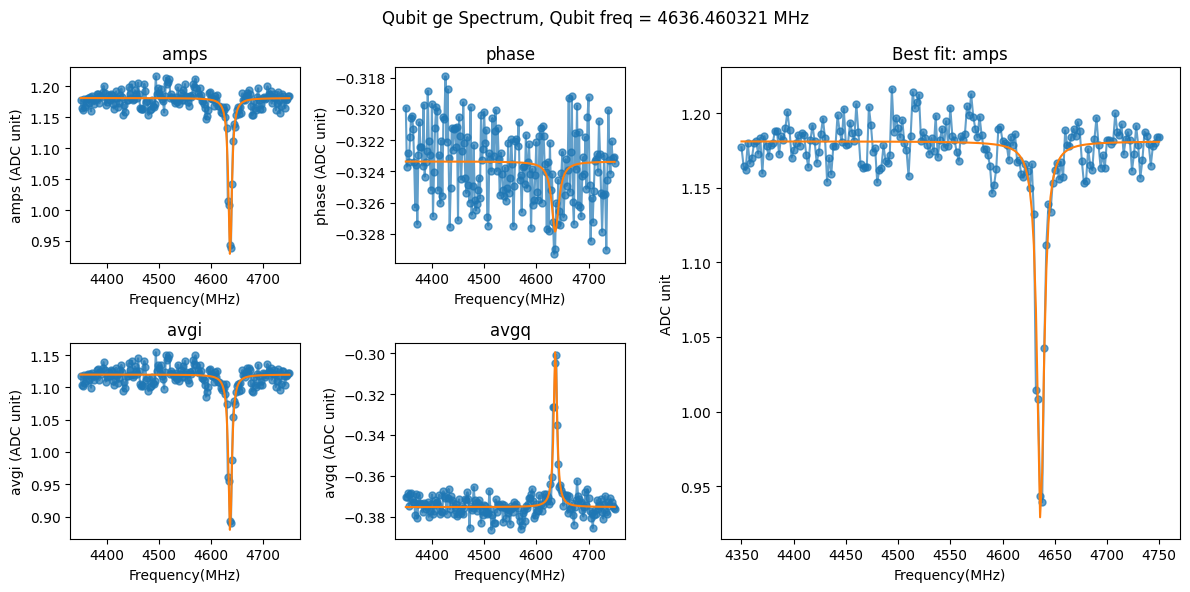

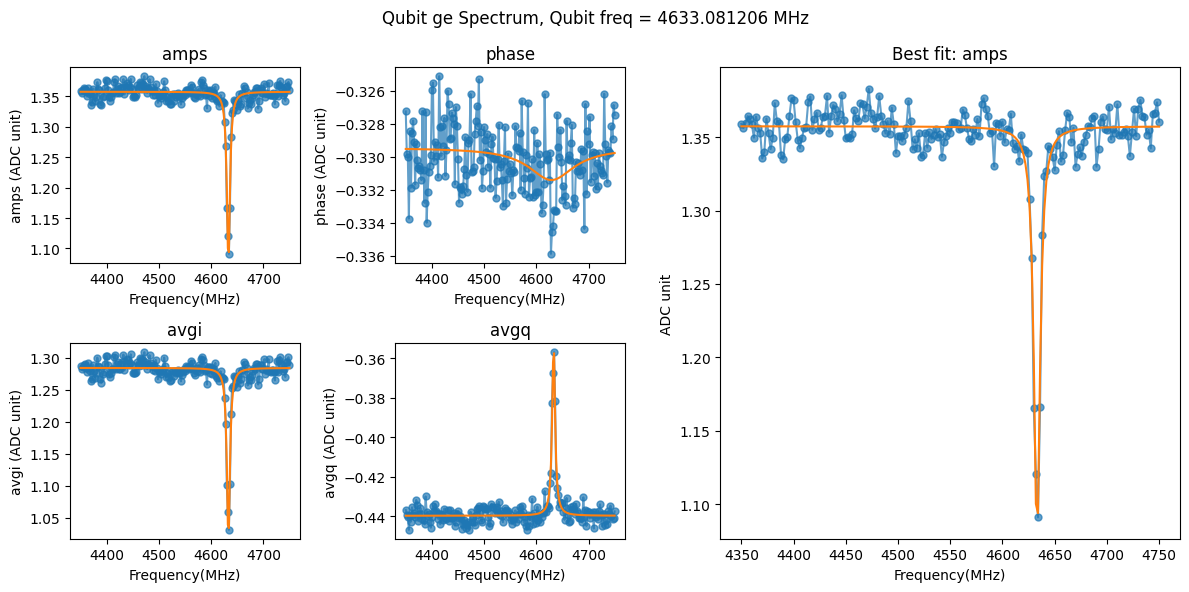

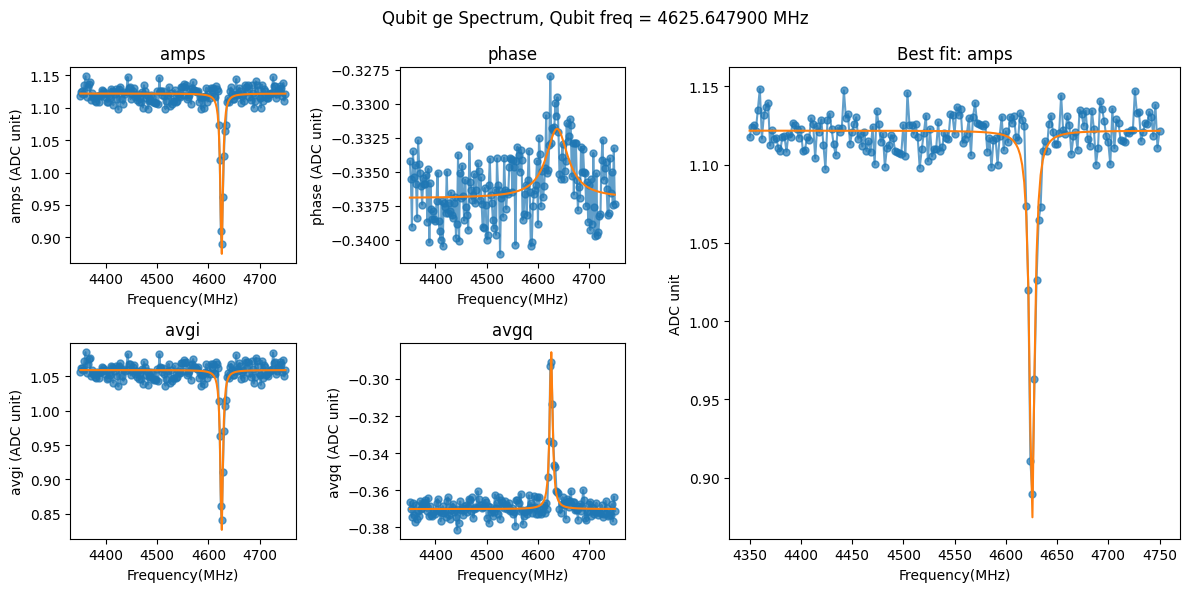

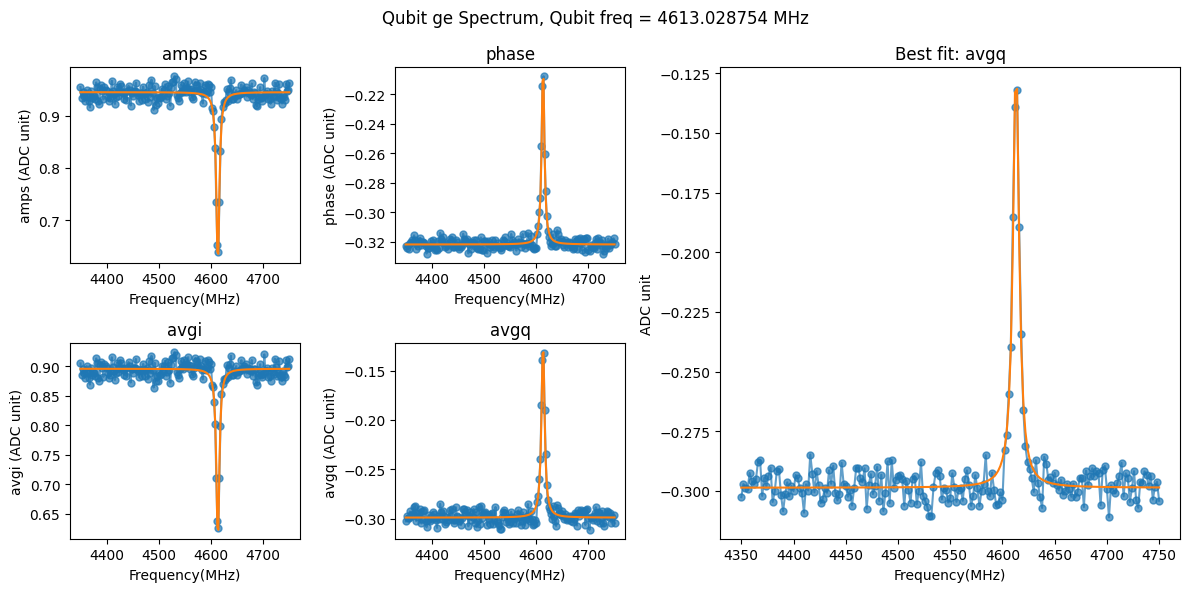

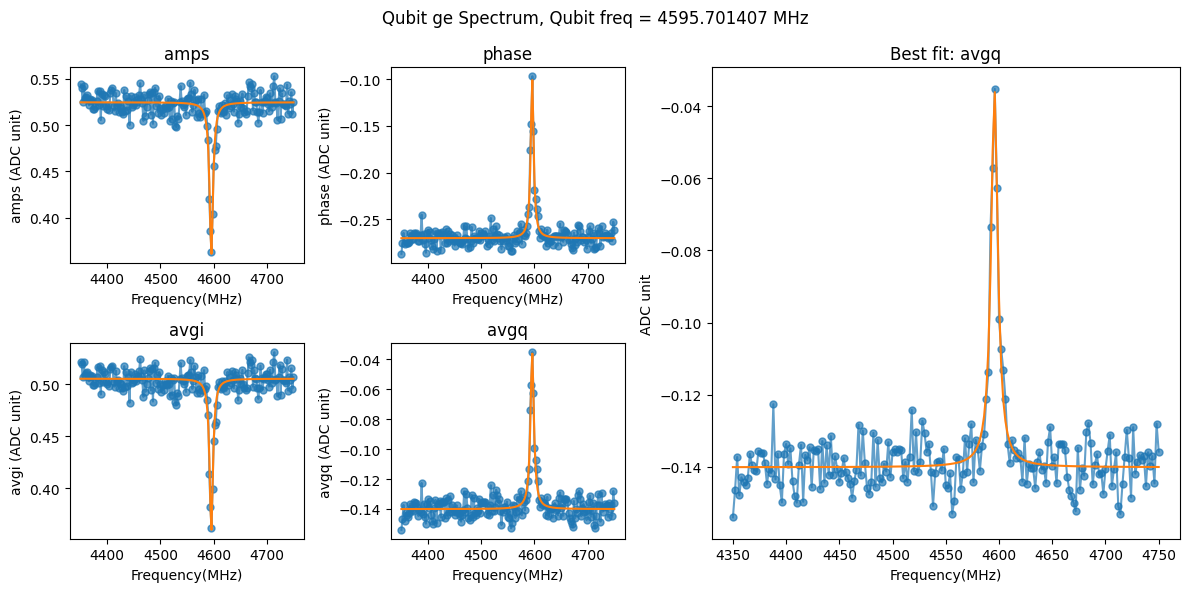

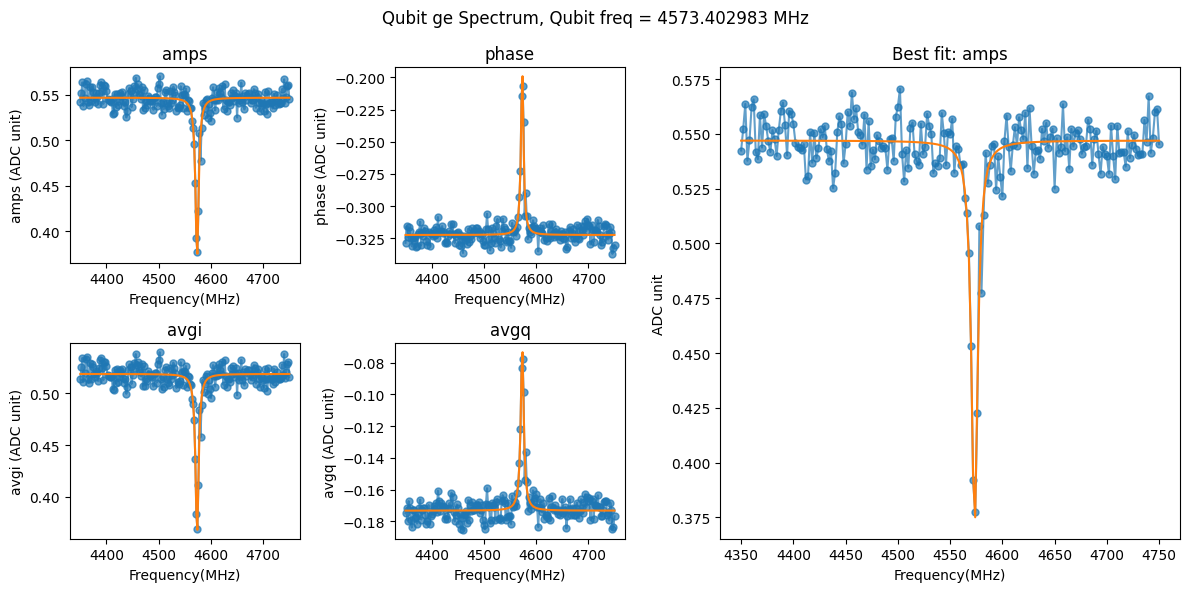

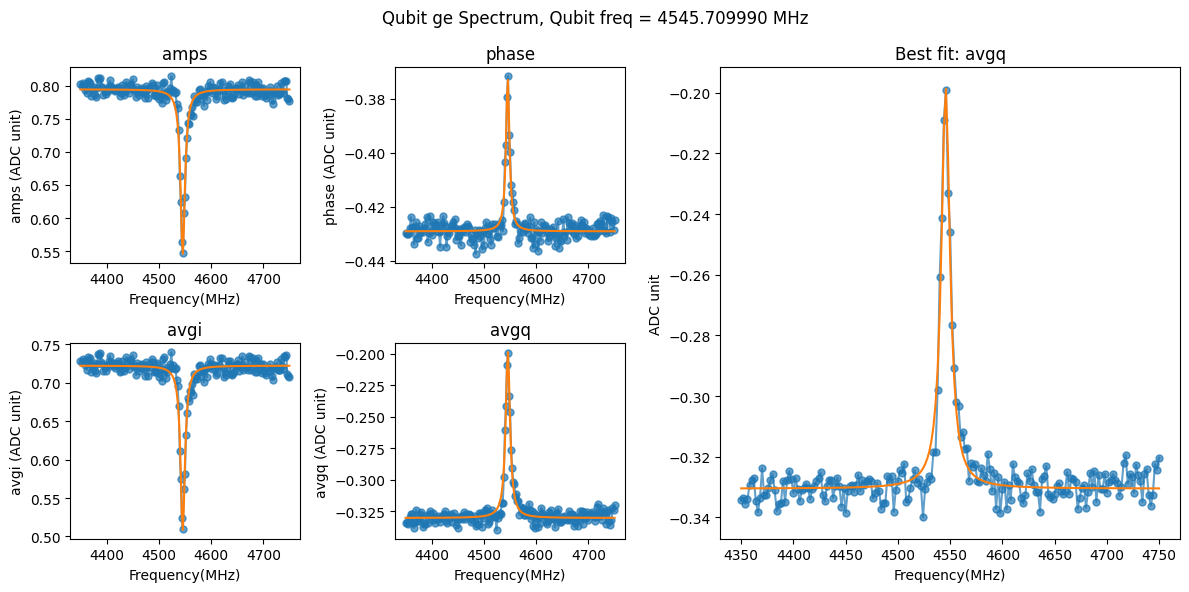

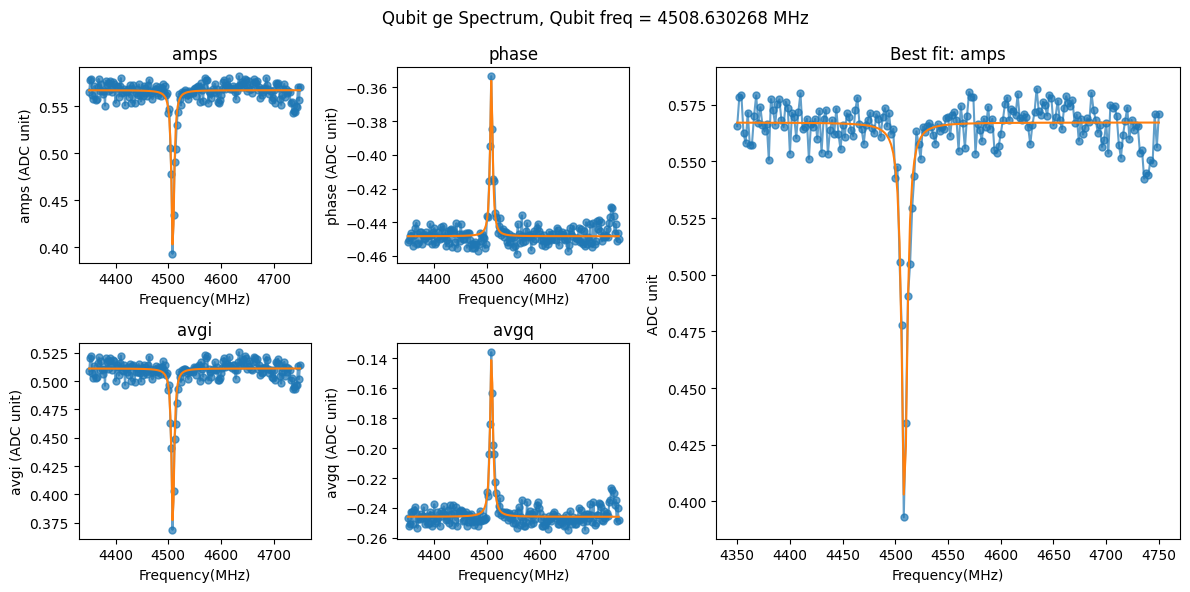

In [11]:
import json

FILENAME = "qubit_auto_test.json"
current = np.array([-2.77, -2.5, -2.3, -2.1, -1.9, -1.7, -1.5, -1.3]) * 1e-3
freq_report = {}


def write_json_report(data_to_save):
    output_data = {
        "unit": {"current": "A", "frequency": "MHz"},
        "qubit_freq_vs_current": data_to_save,
    }

    with open(FILENAME, "w") as f:
        json.dump(output_data, f, indent=4)


if os.path.exists(FILENAME):
    try:
        with open(FILENAME, "r") as f:
            existing_data = json.load(f)
            freq_report = existing_data.get("qubit_freq_vs_current", {})
        print(f"Loaded existing data from {FILENAME}. Resuming sweep.")
    except json.JSONDecodeError:
        print(f"Error reading existing JSON file. Starting new report.")

print(f"--- Starting Qubit Two-tone Sweep, saving to {FILENAME} ---")

for i in current:
    current_mA = i
    current_key = f"{current_mA:.4f} A"

    if current_key in freq_report:
        print(f"Skipping {current_key}. Data already exists.")
        continue

    yoko.SetCurrent(i)
    print(yoko.GetCurrent())

    spectrum_ge = Qubit_Twotone(soc, soccfg, run_cfg)
    f_ge_mhz = spectrum_ge.run(30, liveplot=True)

    freq_report[current_key] = round(f_ge_mhz, 6)

    print(f"Current: {current_key}, Qubit Freq: {f_ge_mhz:.6f} MHz")

    write_json_report(freq_report)

print(f"\nSuccessfully finished sweep. Final report saved to {FILENAME}")

## Qubit Spectrum ge Flux

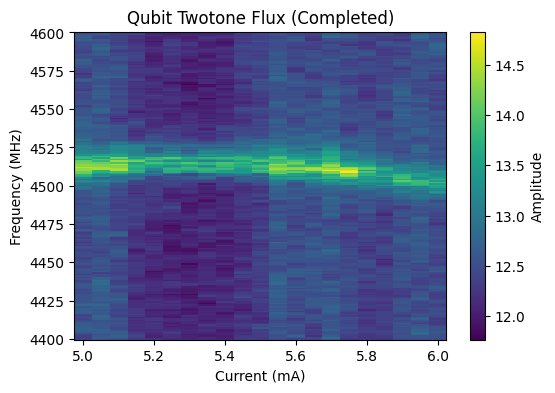

2025-11-06 13:38:09,482 - SR_Network:BlockingClient - Error: Socket operation timed out


Data save to C:\Users\QEL\Desktop\2DQ12round3\2025\11\Data_1106\003_qubit_flux_spec_ge_Q3_033


In [6]:
from qick_workspace.scrip.s003a_qubit_flux_spec_ge import (
    Qubit_Twotone_Flux,
)

run_cfg = select_config_idx(config, qubit_idx)

center = 4500
SPAN = 100
START_FREQ = center - SPAN  # [MHz]
STOP_FREQ = center + SPAN  # [MHz]
STEPS = 201

Start_flux = 5e-3
Stop_flux = 6e-3
Steps_flux = 21
yoko_range = np.linspace(Start_flux, Stop_flux, Steps_flux)

config["nqz_qubit"] = 2
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixe_freq", center),
        ("qubit_gain_ge", 0.3),
        ("res_gain_ge", 0.2),
        ("qubit_length_ge", 2.0),
        ("relax_delay", 1),
        ("cooling", False),
        ("qubit_ch", 7),
    ]
)

spectrum_ge_flux = Qubit_Twotone_Flux(soc, soccfg, run_cfg)
spectrum_ge_flux.run(
    10, liveplot=True, yoko_inst=yoko_connect, yoko_value=yoko_range, mode="current"
)
spectrum_ge_flux.saveLabber(qubit_idx, yoko_range, mode="current")

## Length Rabi ge

Scan interrupted at average: 3


2025-11-06 13:18:00,165 - SR_Network:BlockingClient - Error: Socket operation timed out


Data save to C:\Users\QEL\Desktop\2DQ12round3\2025\11\Data_1106\004_time_rabi_ge_Q3_0.0050777A.hdf5


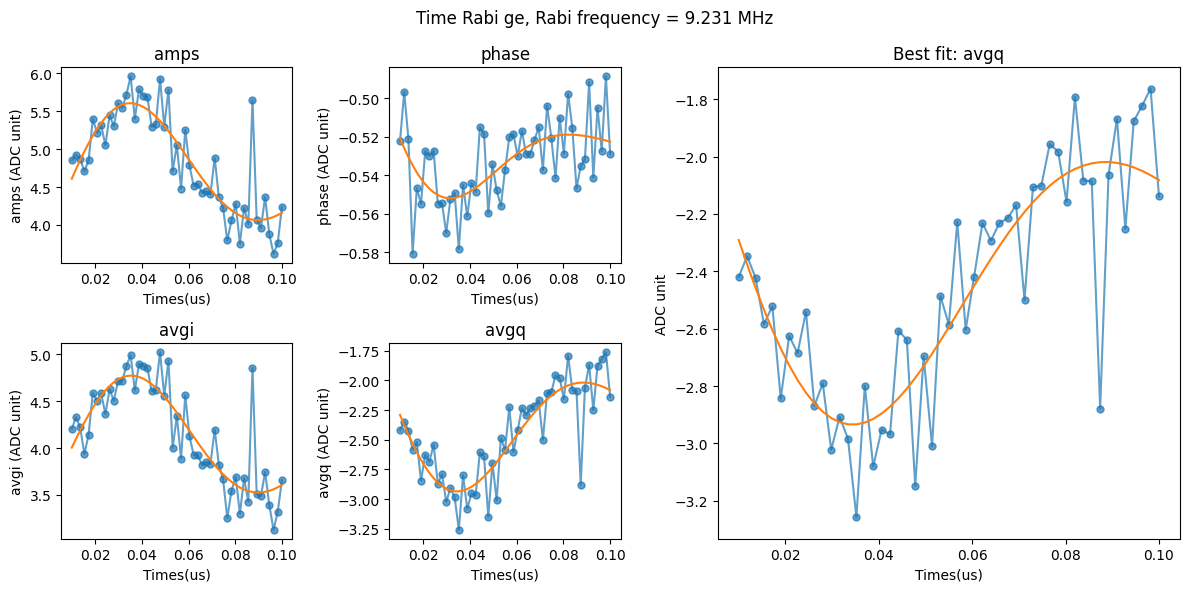

In [42]:
from qick_workspace.scrip.s004_time_rabi_ge import Time_Rabi

time_array = np.linspace(0.01, 0.1, 51)
config["sigma"][qubit_idx] = 0.05
config["relax_delay"] = 50  # [us]
run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("cooling", False),
        ("qubit_ch", 7),
        ("qubit_gain_ge", 0.3),
        ("res_gain_ge", 0.2),
    ]
)

Trabi = Time_Rabi(soc, soccfg, run_cfg)
Trabi.run(20, liveplot=True, time_axis=time_array)
Trabi.saveLabber(qubit_idx, yoko_value=yoko_value)

## Power Rabi ge

[4.99105379e-01 8.84948687e-01 1.11197671e+02 1.48020299e-07
 1.91958257e-01]


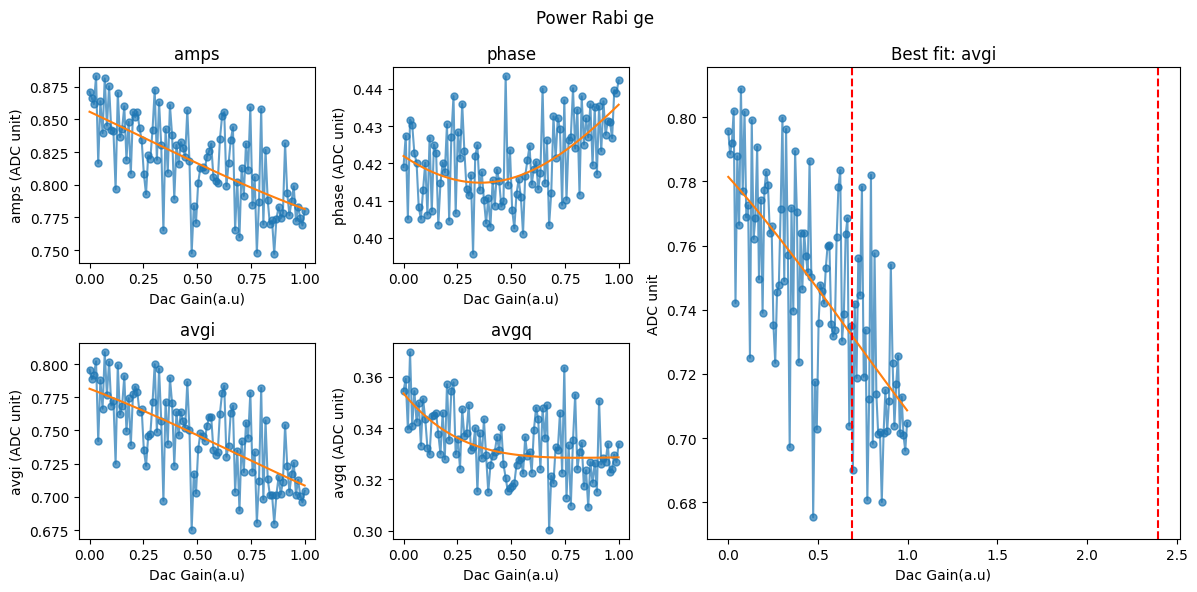

In [ ]:
from qick_workspace.scrip.s005_power_rabi_ge import Amp_Rabi


START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100

config["sigma"][qubit_idx] = 0.005
config["relax_delay"] = 50  # [us]
run_cfg = select_config_idx(config, qubit_idx)

run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_gain_ge", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
        ("cooling", False),
        ("qubit_ch", 5),
    ]
)

prabi = Amp_Rabi(soc, soccfg, run_cfg)
config["qubit_pi_gain_ge"][qubit_idx], config["qubit_pi2_gain_ge"][qubit_idx], error = (
    prabi.run(2, liveplot=True)
)
print(error)
# prabi.saveLabber(qubit_idx, yoko_value=yoko_value)

## Ramsey

Experiment interrupted at 7 averages. Fit is based on partial data.


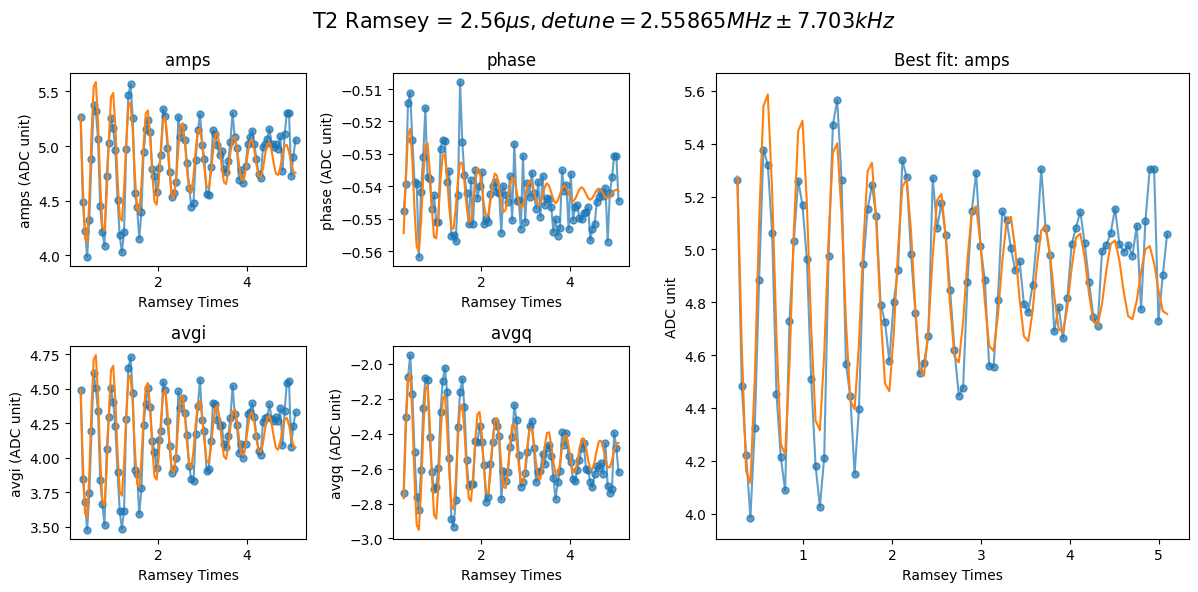

In [48]:
from qick_workspace.scrip.s006_Ramsey_ge import Ramsey

run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 5  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 2),
        ("cooling", False),
        ("qubit_ch", 7),
    ]
)

t2r = Ramsey(soc, soccfg, run_cfg)
t2r.run(20, liveplot=True)
# t2r.saveLabber(qubit_idx, yoko_value=yoko_value)


In [49]:
config["qubit_freq_ge"][qubit_idx] = t2r.correct_detune()

over detune 0.55865MHz


## Echo

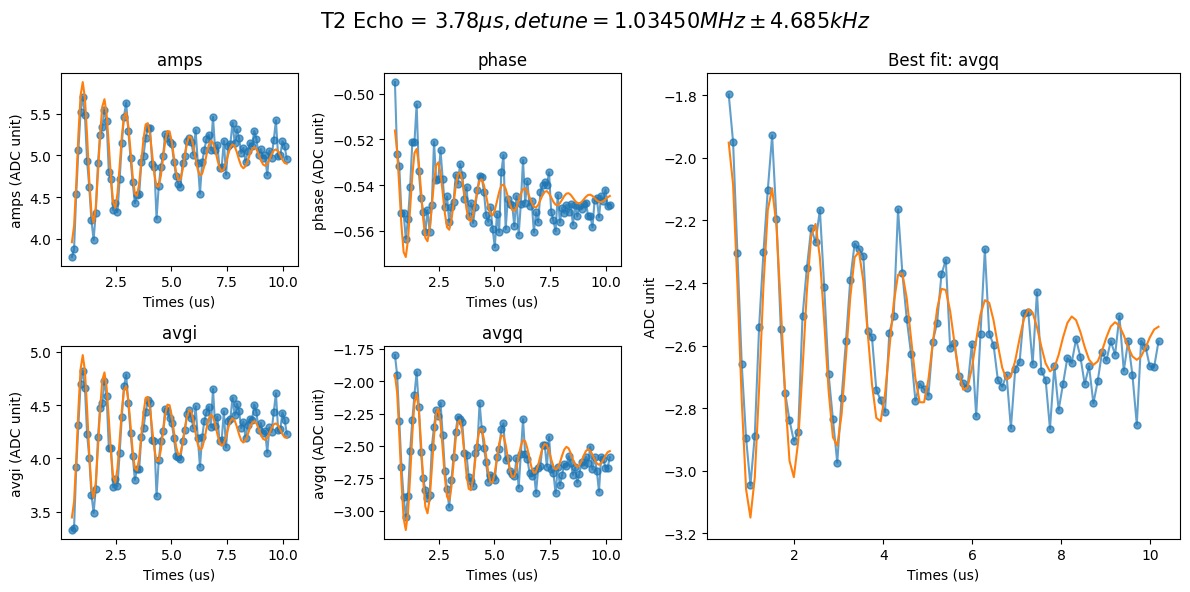

In [50]:
from qick_workspace.scrip.s007_SpinEcho_ge import SpinEcho

run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 10  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 1),
        ("cooling", False),
        ("qubit_ch", 7),
    ]
)

t2e = SpinEcho(soc, soccfg, run_cfg)
t2e.run(20, liveplot=True)

# t2e.saveLabber(qubit_idx, yoko_value=yoko_value)

## T1

2025-11-06 13:20:47,701 - SR_Network:BlockingClient - Error: Socket operation timed out


Data save to C:\Users\QEL\Desktop\2DQ12round3\2025\11\Data_1106\s008_T1_ge_Q3_0.0050777A.hdf5


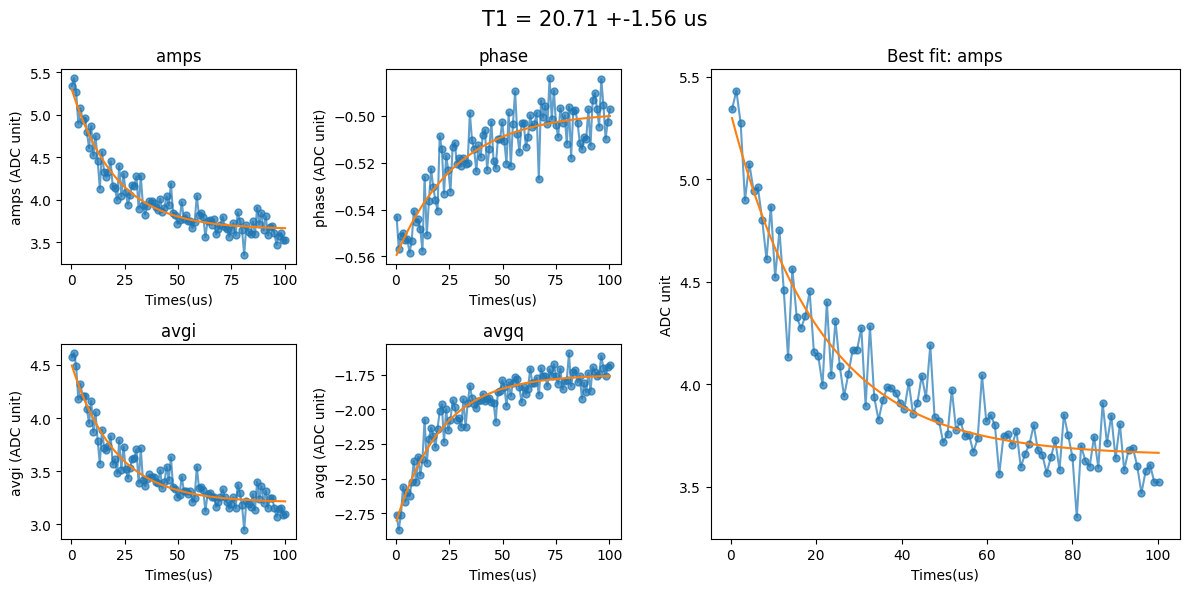

In [51]:
from qick_workspace.scrip.s008_T1_ge import T1

run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 100  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("relax_delay", 50),
        ("cooling", False),
        ("qubit_ch", 7),
    ]
)

t1 = T1(soc, soccfg, run_cfg)
t1.run(50, liveplot=True)
t1.saveLabber(qubit_idx, yoko_value=yoko_value)

## Single shot

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

g unrotated averages:
I 2.9397376693766937 +/- 2.526720182879591 	 Q -2.200212466124661 +/- 2.1617208930093326 	 Amp 4.040444470727095 +/- 2.866208827293934
Rotated (theta=0.6843543828968429):
I 3.668703847253244 +/- 3.0445054494187573 	 Q 0.15363769717073406 +/- 1.3372878038416527 	 Amp 3.6719194518456804 +/- 2.866208827293934
e unrotated averages:
I 5.943868292682926 +/- 3.214350700469414 	 Q -4.651248780487805 +/- 2.4904649195442694 	 Amp 7.7865575627624235 +/- 3.587153852516912
Rotated (theta=0.6843543828968429):
I 7.545865156279882 +/- 3.8160364615624953 	 Q 0.15363769717073272 +/- 1.4043972604339736 	 Amp 7.547429065499769 +/- 3.587153852516912


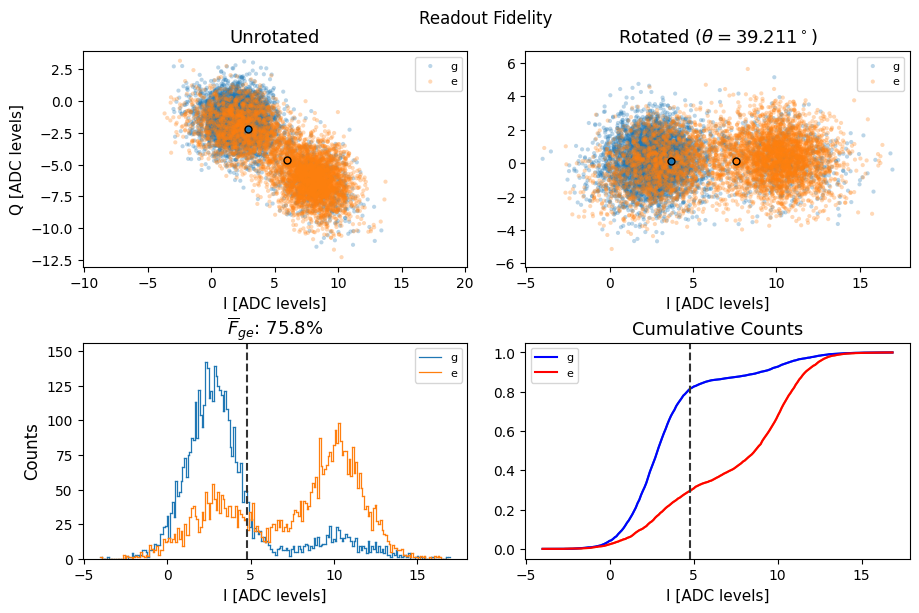

fidelity:[np.float64(0.7581)] 
thressholds:[np.float64(4.793412054532035)] 
theta:39.210617831269026

        Fidelity Matrix:
        -----------------
        | 80.800% | 19.200% |
        ----------------
        | 29.180% | 70.820% |
        -----------------
        IQ plane rotated by: 39.2°
        Threshold: 4.793e+00
        Fidelity: 75.810%
        


In [53]:
from qick_workspace.scrip.s000_SingleShot_prog import SingleShot_gef

run_cfg = select_config_idx(config, qubit_idx)
run_cfg["qubit_ch"] = 7

run_cfg["ro_length"] = 1.2
run_cfg["res_gain_ge"] = 0.2


SHOT = 5000
ssh = SingleShot_gef(soc, soccfg, run_cfg)
ssh.run(SHOT)
ssh.plot(fid_avg=True)

### Single Shot optimize

In [54]:
from qick_workspace.scrip.s000_SingleShot_ge_prog_opt import (
    SingleShot_ge_opt,
)

run_cfg = select_config_idx(config, qubit_idx)
SHOT = 2


freq_axis = np.linspace(5796 - 1, 5796 + 1, 11)
gain_axis = np.linspace(0.1, 0.3, 21)
length_axis = np.linspace(0.2, 1.5, 21)
sweep_para = {"freq": freq_axis, "gain": gain_axis, "length": 0.601}


ssh = SingleShot_ge_opt(soc, soccfg, run_cfg)
ssh.run(SHOT, sweep_para)
ssh.analyze()

Gain loop:   0%|          | 0/21 [00:00<?, ?it/s]

Freq loop:   0%|          | 0/11 [00:00<?, ?it/s]

Freq loop:   0%|          | 0/11 [00:00<?, ?it/s]

Freq loop:   0%|          | 0/11 [00:00<?, ?it/s]

Freq loop:   0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

# EF state (Not repaired yet)

## Cooling to e

In [ ]:
from single_qubit_pyscrip_v1_1.s002d_res_cooling_ge import SingleToneSpectroscopyCooling

run_cfg = select_config_idx(config, qubit_idx)

START_FREQ_1 = 3150  # [MHz]
STOP_FREQ_1 = 3300  # [MHz]
STEPS_freq_1 = 51

START_FREQ_2 = 1900  # [MHz]
STOP_FREQ_2 = 2050  # [MHz]
STEPS_freq_2 = 51

config.update(
    [
        ("cool_ch1", 5),
        ("cool_gain_1", 0.8),
        ("nqz_cool_ch1", 2),
        ("cool_mixer1", 3000),
        ("cool_ch2", 2),
        ("cool_gain_2", 0.4),
        ("nqz_cool_ch2", 2),
        ("cool_mixer2", 2000),
        ("cool_length", 1),
    ]
)

run_cfg.update(
    [
        ("f_steps1", STEPS_freq_1),
        ("cool_freq_1", QickSweep1D("freqloop1", START_FREQ_1, STOP_FREQ_1)),
        ("f_steps2", STEPS_freq_2),
        ("cool_freq_2", QickSweep1D("freqloop2", START_FREQ_2, STOP_FREQ_2)),
    ]
)
cooling = SingleToneSpectroscopyCooling(soc, soccfg, run_cfg)
cooling.run(py_avg=20, liveplot=True)
# cooling.saveLabber(qubit_idx)

KeyboardInterrupt: 

## Onetone EF

c:\Users\QEL\Desktop\tprocv2_guidemo-2DQ12\single_qubit_pyscrip_v1_1\abcd_rf_fit\abcd_rf_fit.py:187: UserWarning: Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False
  warnings.warn("Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False", UserWarning)


{'Fres(GHz)': 7.5215, 'Qi': 27, 'Ql': 1956, 'absQc': -28, 'κ(MHz)': 3.85}


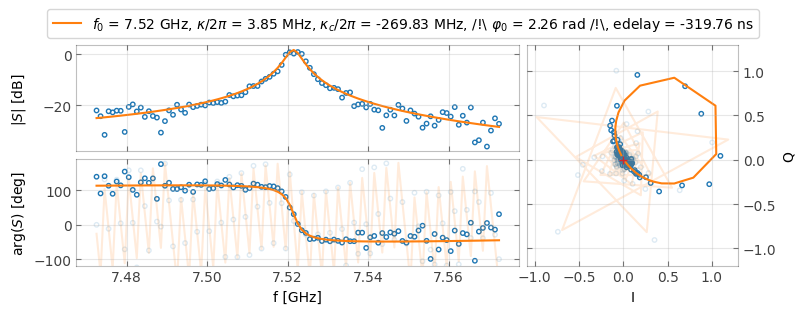

In [ ]:
from single_qubit_pyscrip_v1_1.s009_res_spec_ef import Resonator_onetone_ef


run_cfg = select_config_idx(config, qubit_idx)

START_FREQ = config["res_freq_ge"][qubit_idx] - 50  # [MHz]
STOP_FREQ = config["res_freq_ge"][qubit_idx] + 50  # [MHz]
STEPS = 101
run_cfg.update(
    [
        ("steps", STEPS),
        ("res_freq_ef", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("res_gain_ef", 0.2),
        ("cooling", False),
    ]
)

onetone_ef = Resonator_onetone_ef(soc, soccfg, run_cfg)
# onetone.run(py_avg=10)
fres = onetone_ef.run(py_avg=10, liveplot=True)
# result = onetone.plot_circle()
## update value ##
config["res_freq_ef"][qubit_idx] = round(fres[0] / 1e6, 4)
# config['res_freq_ef'][qubit_idx] = config['res_freq_ge'][qubit_idx]
# onetone_ef.saveLabber(qubit_idx, save_sim=True)|

## Qubit Spectrum ef

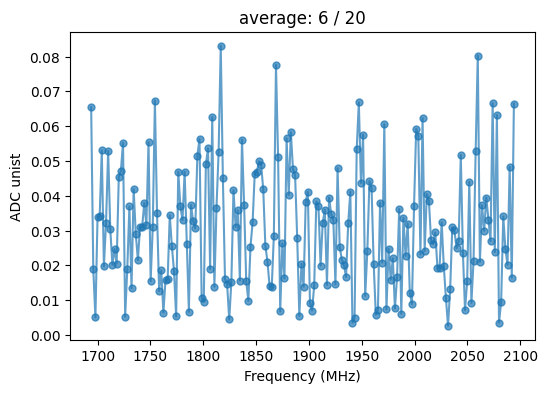

KeyboardInterrupt: 

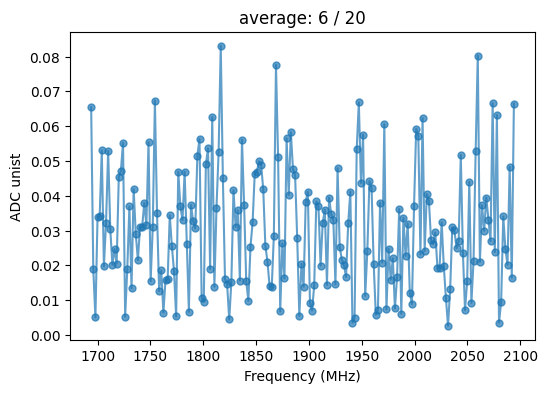

In [ ]:
from single_qubit_pyscrip_v1_1.s010_qubit_spec_ef import Qubit_Twotone_ef

run_cfg = select_config_idx(config, qubit_idx)

cemter = 1894
SPAN = 200
START_FREQ = cemter - SPAN  # [MHz]
STOP_FREQ = cemter + SPAN  # [MHz]
STEPS = 200

config["qubit_ch_ef"][qubit_idx] = 2


config.update(
    [
        ("nqz_qubit_ef", 2),
    ]
)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_freq_ef", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixer_freq_ef", 2200),
        ("qubit_gain_ef", 0.2),
        ("nqz_qubit_ef", 2),
        ("relax_delay", 50),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

spectrum_ge = Qubit_Twotone_ef(soc, soccfg, run_cfg)
f_ef = spectrum_ge.run(20, liveplot=True)
config["qubit_freq_ef"][qubit_idx] = f_ef
config["qmixer_freq_ef"][qubit_idx] = f_ef
spectrum_ge.saveLabber(qubit_idx, save_sim=True)

## Rabi EF

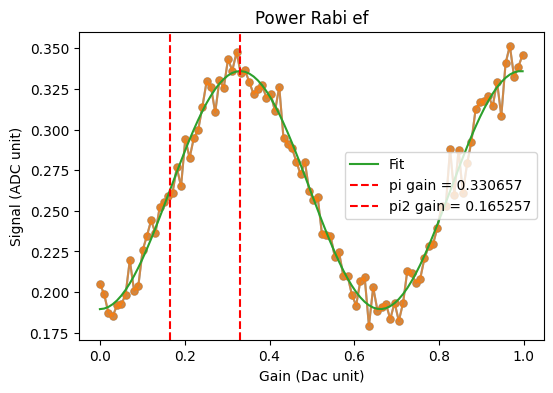

In [ ]:
from single_qubit_pyscrip_v1_1.s011_power_rabi_ef import Amp_Rabi_ef


START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100


config["sigma_ef"][qubit_idx] = 0.02
config["relax_delay"] = 50
run_cfg = select_config_idx(config, qubit_idx)

run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_gain_ef", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

prabi = Amp_Rabi_ef(soc, soccfg, run_cfg)
config["qubit_pi_gain_ef"][qubit_idx], config["qubit_pi2_gain_ef"][qubit_idx] = (
    prabi.run(50, liveplot=True)
)
# a, b = prabi.run(50, liveplot=True)
# config['qubit_pi_gain_ge'][qubit_idx], config['qubit_pi2_gain_ge'][qubit_idx] = prabi.plot()
# prabi.saveLabber(qubit_idx)

## Ramsey ef

over detune 0.02285MHz


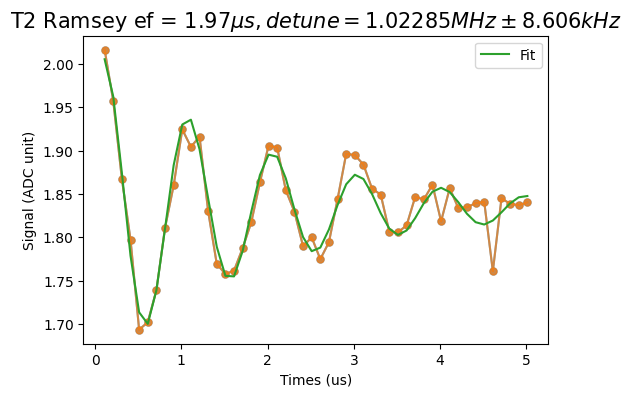

In [ ]:
from single_qubit_pyscrip_v1_1.s012_Ramsey_ef import Ramsey_ef

run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 5  # [us]
STEPS = 50
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 1),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

t2r_ef = Ramsey_ef(soc, soccfg, run_cfg)
t2r_ef.run(20, liveplot=True)
# tt2r_ef2r.plot()
config["qubit_freq_ef"][qubit_idx] = t2r_ef.correct_detune()
# t2r_ef.saveLabber(qubit_idx, 0, save_sim=True)


## T1 ef

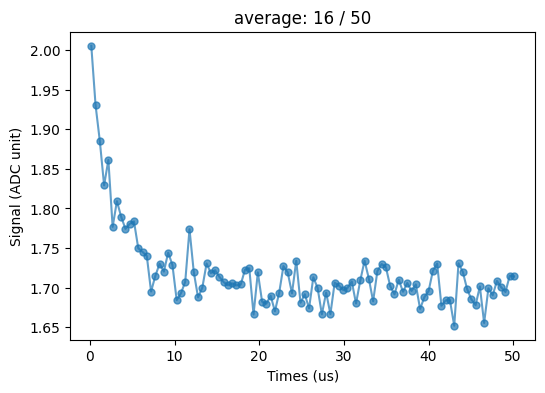

KeyboardInterrupt: 

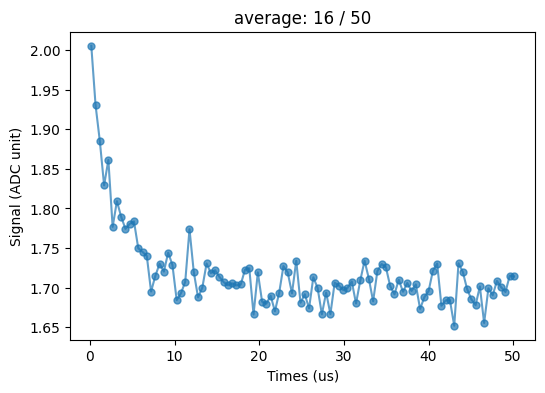

In [ ]:
from single_qubit_pyscrip_v1_1.s013_T1_ef import T1_ef

run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 50  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("relax_delay", 100),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

t1_ef = T1_ef(soc, soccfg, run_cfg)
t1_ef.run(50, liveplot=True)


# t1.saveLabber(qubit_idx, 0, save_sim=True)

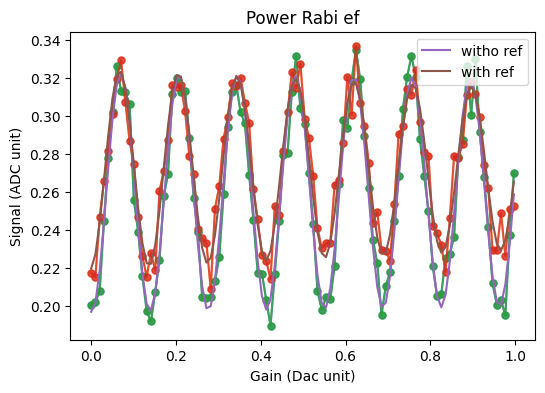

In [ ]:
from single_qubit_pyscrip_v1_1.s013_qubit_temp import Qubit_temperature


START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100


config["sigma_ef"][qubit_idx] = 0.1
config["relax_delay"] = 100
run_cfg = select_config_idx(config, qubit_idx)

run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_gain_ef", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

prabi = Qubit_temperature(soc, soccfg, run_cfg)
# config['qubit_pi_gain_ef'][qubit_idx], config['qubit_pi2_gain_ef'][qubit_idx] = prabi.run(50, liveplot=True)
x, y = prabi.run(50, liveplot=True)
# config['qubit_pi_gain_ge'][qubit_idx], config['qubit_pi2_gain_ge'][qubit_idx] = prabi.plot()
# prabi.saveLabber(qubit_idx)

# ALLXY

  0%|          | 0/21 [00:00<?, ?it/s]

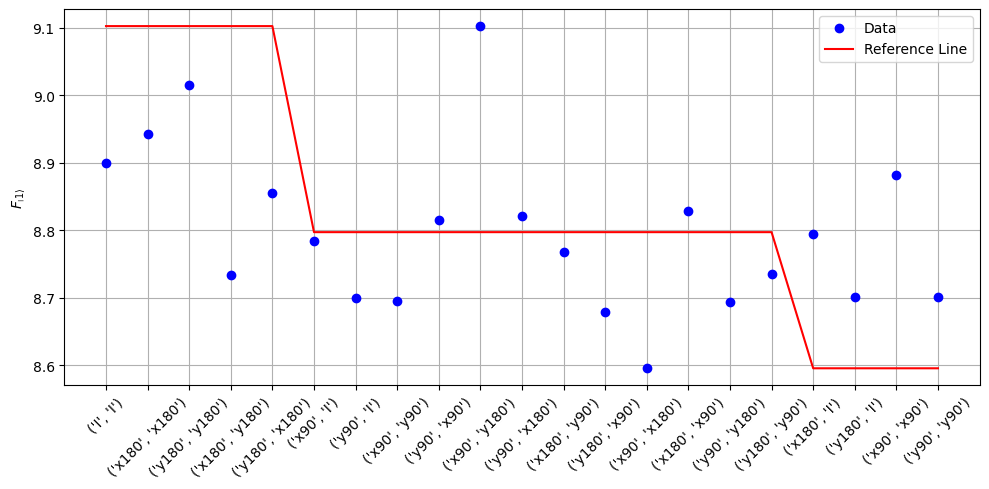

In [55]:
from qick_workspace.scrip.s014_AllXY import AllXY

run_cfg.update([("cooling", False)])
allxy = AllXY(soc, soccfg, run_cfg)
allxy.run(10)
allxy.plot()

# State Tomography

Calibrating |0> state...
Calibrating |1> state...
IQ Ground (|0>): (3.2496334635416666-1.8125332031249997j)
IQ Excited (|1>): (3.390513671875-1.8803938802083333j)
Running tomography for state prepared by: x180


Tomography (State: x180):   0%|          | 0/3 [00:00<?, ?it/s]

Raw Tomography IQ data: {'X': np.complex128(3.1247434895833335-1.6389407552083335j), 'Y': np.complex128(2.9290957031249993-1.5551842447916668j), 'Z': np.complex128(3.1643763020833333-1.7195566406250002j)}

Measured Expectation Values:
  <X> = 1.0000
  <Y> = 1.0000
  <Z> = 1.0000

--- Raw Density Matrix (before MLE) ---
[[1. +0.j  0.5-0.5j]
 [0.5+0.5j 0. +0.j ]]

--- Final MLE Reconstructed Density Matrix ---
[[0.78867513+0.j         0.28867513-0.28867513j]
 [0.28867513+0.28867513j 0.21132487+0.j        ]]

Purity: 1.00000 (1.0 = pure state)


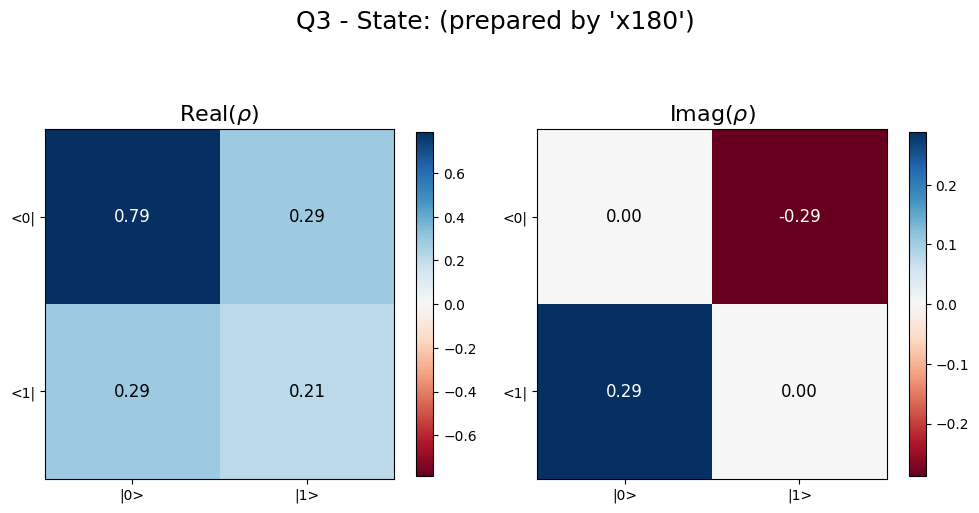

c:\Users\QEL\Desktop\SQC_soc\qick_workspace\scrip\s016_state_tomography.py:511: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


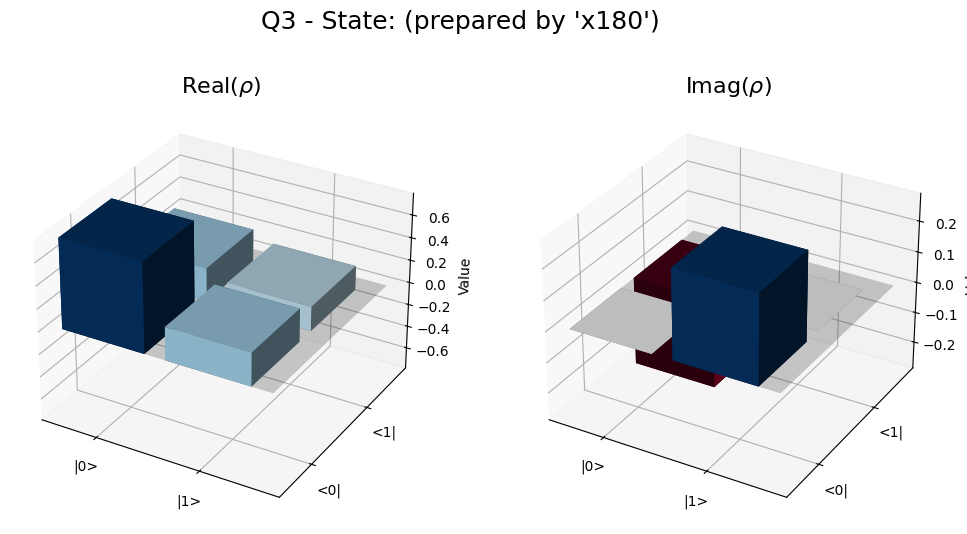

(<Figure size 1200x600 with 2 Axes>,
 (<Axes3D: title={'center': 'Real($\\rho$)'}, zlabel='Value'>,
  <Axes3D: title={'center': 'Imag($\\rho$)'}, zlabel='Value'>))

In [56]:
from qick_workspace.scrip.s016_state_tomography import Tomography

pyavg = 10


run_cfg = select_config_idx(config, qubit_idx)
run_cfg["cooling"] = False
tomo = Tomography(soc, soccfg, run_cfg)

tomo.run(py_avg=pyavg, prep_pulse_name="x180")

tomo.plot(plot_type="2d", qb_idx=3)
tomo.plot(plot_type="3d", qb_idx=3)

# Randomized Benchmarking


--- Running Standard RB (Ref) ---


Standard RB depth:   0%|          | 0/20 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

[1.33908914e-08 1.78546425e-09 3.57092534e+00]
0.0 19803963380233.758 0.0008794726479532983

--- Fitting Results for: Ref ---
  Fitted p = 0.000001 ± 0.000000 %
  Error per Clifford (EPC) = 49.999999 ± 0.000000 %


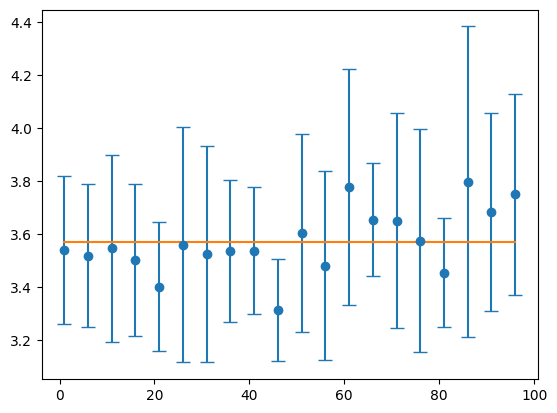

In [57]:
from qick_workspace.scrip.s015_Single_qubit_RB import (
    RandomizedBenchmarking,
)

run_cfg = select_config_idx(config, qubit_idx)


py_avg = 1
max_circuit_depth = 100
delta_clifford = 5
number_sample = 10


all_rb_results = []


print("\n--- Running Standard RB (Ref) ---")
rb_exp_ref = RandomizedBenchmarking(soc, soccfg, run_cfg)
rb_exp_ref.run(
    py_avg=py_avg,
    max_circuit_depth=max_circuit_depth,
    delta_clifford=delta_clifford,
    number_sample=number_sample,
    interleaved_gate=None,
)
rb_exp_ref.plot(label="Ref")

all_rb_results.append(rb_exp_ref)

## Interleve RB

In [ ]:
# interleaved_gates_to_test = ["X", "X/2", "-X/2", "Y", "Y/2", "-Y/2"]
interleaved_gates_to_test = ["X", "X/2", "Y", "Y/2"]

for gate in interleaved_gates_to_test:
    print(f"\n--- Running Interleaved RB ({gate}) ---")
    rb_exp_irb = RandomizedBenchmarking(soc, soccfg, run_cfg)
    rb_exp_irb.run(
        py_avg=py_avg,
        max_circuit_depth=max_circuit_depth,
        delta_clifford=delta_clifford,
        number_sample=number_sample,
        interleaved_gate=gate,
    )
    all_rb_results.append(rb_exp_irb)